# Exploratory Data Analysis (EDA) — Workshop 3: Happiness Prediction

## Objective

The purpose of this notebook is to **explore and analyze the happiness data** from five different years (2015 to 2019) to:
- Understand the structure and quality of the data,
- Unify the datasets into a single consistent structure,
- Identify patterns, correlations, and potential issues (like nulls or outliers),
- Select the most relevant features (variables) to predict the **Happiness Score**,
- And prepare the data for model training before moving to the Kafka streaming phase.

---

## Why is EDA important *before* machine learning?

EDA (Exploratory Data Analysis) is the foundation for building a reliable model. It allows us to:
- Understand the **range, type, and distribution** of each variable.
- Detect **inconsistencies** across datasets (e.g., different column names or units between years).
- Handle **missing values**, standardize categories, or engineer new features.
- Reveal **correlations and redundancies** between variables.
- Guide the **selection of features** that are most useful for prediction.

Without EDA, we risk feeding poor quality data into the model, which will lead to **low accuracy, poor generalization**, and misleading conclusions.

---

## Structure of the data

Each CSV file contains happiness-related information for multiple countries in a given year. However, some columns may:
- Be **missing or renamed** across years (e.g., `Economy (GDP per Capita)` vs `GDP per capita`),
- Represent **categories** (e.g., `Region`, `Country`),
- Be **numeric features** (e.g., `Happiness Score`, `Health`, `Freedom`, `Trust`, etc.).

To make the data usable:
- We’ll first standardize all columns and merge them into one unified DataFrame.
- Then, we’ll analyze variable types, distributions, and correlations.

---

## Goals of this EDA

✅ Clean and combine datasets from all 5 years  
✅ Understand the distribution of each feature  
✅ Identify missing values or inconsistencies  
✅ Analyze feature importance using correlation and model-based ranking  
✅ Prepare the dataset for training regression models

---

Once the EDA is complete, we'll move on to:
- Train multiple regression models (e.g., Linear, Random Forest, Gradient Boosting),
- Evaluate performance using metrics like **MAE**, **MSE**, and **R²**,  
- And finally integrate the model into a Kafka streaming pipeline.

Let's get started! 

#### Overview

This block loads and merges annual happiness datasets (2015–2019), appends the year column, and identifies numerical and categorical columns. It summarizes basic statistics for numerical variables and lists unique values for categorical features.

In [7]:
import polars as pl
from pathlib import Path

data_dir = Path("../data/raw")
years = range(2015, 2020)

dfs = []
for year in years:
    file = data_dir / f"{year}.csv"
    if file.exists():
        df = pl.read_csv(file)
        df = df.with_columns(pl.lit(year).alias("year"))
        dfs.append(df)

df_all = pl.concat(dfs, how="diagonal_relaxed")
schema = df_all.schema

numeric_cols = [col for col, dtype in schema.items() if dtype in [pl.Int64, pl.Int32, pl.Float64, pl.Float32]]
categorical_cols = [col for col, dtype in schema.items() if dtype == pl.Utf8]

print("\nNumeric column statistics:")
for col in numeric_cols:
    print(f"\nColumn: {col}")
    print(df_all.select([
        pl.col(col).min().alias("min"),
        pl.col(col).max().alias("max"),
        pl.col(col).mean().alias("mean"),
        pl.col(col).std().alias("std"),
        pl.col(col).null_count().alias("nulls")
    ]))

print("\nUnique values by categorical column:")
for col in categorical_cols:
    unique_vals = df_all.select(pl.col(col)).unique().drop_nulls().to_series().to_list()
    print(f"\nColumn: {col} ({len(unique_vals)} unique)")
    print(unique_vals)



Numeric column statistics:

Column: Happiness Rank
shape: (1, 5)
┌─────┬─────┬───────────┬───────────┬───────┐
│ min ┆ max ┆ mean      ┆ std       ┆ nulls │
│ --- ┆ --- ┆ ---       ┆ ---       ┆ ---   │
│ i64 ┆ i64 ┆ f64       ┆ f64       ┆ u32   │
╞═════╪═════╪═══════════╪═══════════╪═══════╡
│ 1   ┆ 158 ┆ 79.238095 ┆ 45.538922 ┆ 467   │
└─────┴─────┴───────────┴───────────┴───────┘

Column: Happiness Score
shape: (1, 5)
┌───────┬───────┬──────────┬──────────┬───────┐
│ min   ┆ max   ┆ mean     ┆ std      ┆ nulls │
│ ---   ┆ ---   ┆ ---      ┆ ---      ┆ ---   │
│ f64   ┆ f64   ┆ f64      ┆ f64      ┆ u32   │
╞═══════╪═══════╪══════════╪══════════╪═══════╡
│ 2.839 ┆ 7.587 ┆ 5.378949 ┆ 1.141531 ┆ 467   │
└───────┴───────┴──────────┴──────────┴───────┘

Column: Standard Error
shape: (1, 5)
┌─────────┬─────────┬──────────┬──────────┬───────┐
│ min     ┆ max     ┆ mean     ┆ std      ┆ nulls │
│ ---     ┆ ---     ┆ ---      ┆ ---      ┆ ---   │
│ f64     ┆ f64     ┆ f64      ┆ f64      ┆

#### Key Observations

- Many numeric columns contain over 400 null values, including `Happiness Score`, `Economy (GDP per Capita)`, `Health (Life Expectancy)`, and `Trust (Government Corruption)`.
- The `year` column spans correctly from 2015 to 2019, with no missing values.
- Several columns appear duplicated under different names, such as `Happiness Score`, `Score`, `Happiness.Score`.
- Categorical columns like `Country`, `Country or region`, and `Perceptions of corruption` show high cardinality (160–180+ unique values).
- The column `Perceptions of corruption` includes the value `'N/A'` among numerical strings, indicating potential data type inconsistency.


#### Overview

This block inspects the full schema of the dataset. For each column, it prints the data type. For categorical columns, it shows the top 10 most frequent values. For numerical columns, it counts non-null entries. This helps verify column consistency, detect duplicates, and assess completeness.

In [9]:
df_all = pl.concat(dfs, how="diagonal_relaxed")
schema = df_all.schema

print("Detailed information for all columns:\n")

for col, dtype in schema.items():
    print(f" Column: {col}")
    print(f"   Data type: {dtype}")

    if dtype == pl.Utf8:
        print("   Value frequency (max 10):")
        freq = (
            df_all
            .filter(pl.col(col).is_not_null())
            .group_by(col)
            .agg(pl.count().alias("count"))
            .sort("count", descending=True)
            .limit(10)
        )
        print(freq)

    elif dtype in [pl.Int64, pl.Int32, pl.Float64, pl.Float32]:
        count = df_all.select(pl.col(col).drop_nulls().count()).item()
        print(f"   Non-null count: {count}")

    print("-" * 60)


Detailed information for all columns:

 Column: Country
   Data type: String
   Value frequency (max 10):
shape: (10, 2)
┌──────────────┬───────┐
│ Country      ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ New Zealand  ┆ 3     │
│ Argentina    ┆ 3     │
│ Iceland      ┆ 3     │
│ Russia       ┆ 3     │
│ Benin        ┆ 3     │
│ Belgium      ┆ 3     │
│ Austria      ┆ 3     │
│ Armenia      ┆ 3     │
│ Canada       ┆ 3     │
│ Saudi Arabia ┆ 3     │
└──────────────┴───────┘
------------------------------------------------------------
 Column: Region
   Data type: String
   Value frequency (max 10):
shape: (10, 2)
┌─────────────────────────────────┬───────┐
│ Region                          ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Sub-Saharan Africa              ┆ 78    │
│ Central and Eastern Europe      ┆ 58    │
│ Latin America and Caribbean

C:\Users\57302\AppData\Local\Temp\ipykernel_2472\3703240932.py:16: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


#### Key Observations

- Categorical columns like `Country`, `Region`, and `Country or region` contain up to 166 unique values and show consistent frequency counts across top entries.
- The column `Perceptions of corruption` is stored as string and includes numerical-like values, indicating it was not parsed as float.
- Some columns appear duplicated under variant names (e.g., `Happiness Rank` vs. `Happiness.Rank`, `Economy (GDP per Capita)` vs. `Economy..GDP.per.Capita.`).
- Several numeric columns have only 155–158 non-null entries (`Standard Error`, `Upper Confidence Interval`, etc.), showing sparse coverage in some versions of the dataset.
- Newer columns like `Score`, `Social support`, and `Freedom to make life choices` have around 312 non-null values, indicating they belong to a later structure.

#### Overview

This block tracks the presence of each country across happiness datasets from 2015 to 2019. It identifies the relevant column containing country names in each file, aggregates the years each country appears, and summarizes the count of appearances per country over the five-year span.

In [ ]:
import polars as pl
from pathlib import Path
from collections import defaultdict, Counter

data_dir = Path("../data/raw")
years = range(2015, 2020)

country_appearance = defaultdict(set)

for year in years:
    file = data_dir / f"{year}.csv"
    if file.exists():
        df = pl.read_csv(file)
        country_col = None
        for col in df.columns:
            if "country" in col.lower():
                country_col = col
                break
        if country_col:
            countries = df.select(pl.col(country_col)).unique().drop_nulls().to_series().to_list()
            for country in countries:
                country_appearance[country].add(year)

country_years_count = Counter({country: len(years_set) for country, years_set in country_appearance.items()})

summary = {
    5: [],
    4: [],
    3: [],
    2: [],
    1: []
}

for country, count in country_years_count.items():
    if count in summary:
        summary[count].append(country)

print("Summary of country appearances:")
for count in sorted(summary.keys(), reverse=True):
    print(f"\nCountries that appear in {count} year(s): {len(summary[count])}")
    print(summary[count])


Summary of country appearances:

Countries that appear in 5 year(s): 141
['Afghanistan', 'Haiti', 'Albania', 'United Kingdom', 'Nepal', 'South Africa', 'Malaysia', 'Sierra Leone', 'Libya', 'Iran', 'Madagascar', 'Syria', 'Slovakia', 'Tajikistan', 'Lithuania', 'El Salvador', 'Myanmar', 'Indonesia', 'Netherlands', 'Morocco', 'Bosnia and Herzegovina', 'Ireland', 'Saudi Arabia', 'Montenegro', 'Burkina Faso', 'Colombia', 'Kuwait', 'Turkey', 'Poland', 'Sweden', 'Jordan', 'Chad', 'Ecuador', 'Canada', 'Congo (Kinshasa)', 'Ghana', 'Kyrgyzstan', 'Qatar', 'South Korea', 'Australia', 'Togo', 'Jamaica', 'Argentina', 'Turkmenistan', 'Singapore', 'Estonia', 'Honduras', 'Brazil', 'Gabon', 'Czech Republic', 'Croatia', 'Chile', 'Malta', 'Guinea', 'Burundi', 'Uganda', 'Algeria', 'Tunisia', 'Switzerland', 'Finland', 'Yemen', 'Azerbaijan', 'Sri Lanka', 'Kenya', 'Kosovo', 'India', 'Palestinian Territories', 'Uzbekistan', 'Zimbabwe', 'Slovenia', 'Mexico', 'United States', 'Senegal', 'Germany', 'Venezuela', 'R

#### Key Observations

- 141 countries appear in all 5 years.
- A small number of countries appear in only 4 (12), 3 (4), or 2 (4) years.
- 9 countries appear in only 1 year.
- Variants in country naming are present (e.g., "Taiwan", "Taiwan Province of China", "Hong Kong", "Hong Kong S.A.R., China").
- Some countries are represented with slightly different formats or duplicate labels (e.g., "Somaliland region" vs. "Somaliland Region").

#### Overview

This block analyzes the structure of the happiness datasets by year. It loads only the first row of each file to extract column names, counts how many times each column appears across the five years, and groups them by frequency of appearance.

In [ ]:
columns_by_year = {}

for year in years:
    file_path = data_dir / f"{year}.csv"
    if file_path.exists():
        df = pl.read_csv(file_path, n_rows=1) 
        columns_by_year[year] = set(df.columns)

column_counts = defaultdict(int)

for cols in columns_by_year.values():
    for col in cols:
        column_counts[col] += 1

grouped_by_frequency = defaultdict(list)
for col, count in column_counts.items():
    grouped_by_frequency[count].append(col)

for freq in sorted(grouped_by_frequency.keys(), reverse=True):
    print(f"\nColumns that appear in {freq} year(s): {len(grouped_by_frequency[freq])}")
    for col in sorted(grouped_by_frequency[freq]):
        print(f" - {col}")


Columns that appear in 5 year(s): 1
 - Generosity

Columns that appear in 3 year(s): 3
 - Country
 - Family
 - Freedom

Columns that appear in 2 year(s): 15
 - Country or region
 - Dystopia Residual
 - Economy (GDP per Capita)
 - Freedom to make life choices
 - GDP per capita
 - Happiness Rank
 - Happiness Score
 - Health (Life Expectancy)
 - Healthy life expectancy
 - Overall rank
 - Perceptions of corruption
 - Region
 - Score
 - Social support
 - Trust (Government Corruption)

Columns that appear in 1 year(s): 11
 - Dystopia.Residual
 - Economy..GDP.per.Capita.
 - Happiness.Rank
 - Happiness.Score
 - Health..Life.Expectancy.
 - Lower Confidence Interval
 - Standard Error
 - Trust..Government.Corruption.
 - Upper Confidence Interval
 - Whisker.high
 - Whisker.low


#### Key Observations

- Several columns appear in all 5 years, indicating core variables present throughout the dataset.
- Many columns appear only in 1 or 2 years, reflecting changes in schema or feature additions/removals across years.
- Column naming is inconsistent across files, with variants such as `Happiness Score`, `Happiness.Score`, `Score`, and `Overall rank`.
- The presence of year-specific columns suggests the need for harmonization before modeling or aggregation.

#### Overview

This block standardizes and merges the happiness datasets from 2015 to 2019. A renaming map is used to unify variations of key variable names across years (e.g., `Score`, `Happiness.Score`, `Happiness Score` all become `Happiness Score`). These standardized columns were selected because they are conceptually consistent across files and represent core predictors for happiness modeling: economic output (`Economy`), social support (`Family`), health, freedom, trust in government, generosity, and a residual factor. Redundant or inconsistent column variants were dropped to avoid duplication and ensure a clean feature set for the final model.

In [10]:
import polars as pl
from pathlib import Path


data_dir = Path("../data/raw")
years = range(2015, 2020)

rename_map = {
    "Country or region": "Country",
    "Country": "Country",

    "Score": "Happiness Score",
    "Happiness.Score": "Happiness Score",
    "Happiness Score": "Happiness Score",

    "Overall rank": "Happiness Rank",
    "Happiness.Rank": "Happiness Rank",
    "Happiness Rank": "Happiness Rank",

    "GDP per capita": "Economy (GDP per Capita)",
    "Economy..GDP.per.Capita.": "Economy (GDP per Capita)",
    "Economy (GDP per Capita)": "Economy (GDP per Capita)",

    "Healthy life expectancy": "Health (Life Expectancy)",
    "Health..Life.Expectancy.": "Health (Life Expectancy)",
    "Health (Life Expectancy)": "Health (Life Expectancy)",

    "Perceptions of corruption": "Trust (Government Corruption)",
    "Trust..Government.Corruption.": "Trust (Government Corruption)",
    "Trust (Government Corruption)": "Trust (Government Corruption)",

    "Freedom to make life choices": "Freedom",
    "Freedom": "Freedom",

    "Social support": "Family",
    "Family": "Family",

    "Dystopia.Residual": "Dystopia Residual",
    "Dystopia Residual": "Dystopia Residual",
}

def standardize_columns(df: pl.DataFrame, rename_map: dict) -> pl.DataFrame:
    return df.rename({col: rename_map[col] for col in df.columns if col in rename_map})

dfs = []

for year in years:
    file = data_dir / f"{year}.csv"
    if file.exists():
        df = pl.read_csv(file)
        df = standardize_columns(df, rename_map)
        df = df.with_columns(pl.lit(year).alias("year"))
        dfs.append(df)

df_merged = pl.concat(dfs, how="diagonal_relaxed")


output_path = Path("../data/processed")
output_path.mkdir(parents=True, exist_ok=True)

df_merged.write_csv(output_path / "happiness_merged.csv")

#### Key Observations

- Multiple columns with variant names were consolidated into standard ones (e.g., `Score`, `Happiness.Score`, `Happiness Score` → `Happiness Score`).
- All yearly datasets were successfully merged into a single file with unified schema.
- The merged dataset was exported as `happiness_merged.csv` in the `processed` folder.

#### Overview

This block loads the merged dataset containing standardized happiness data from 2015 to 2019. It inspects the overall shape, column types, and the first few records. It also verifies the presence and content of the `year` column to confirm proper temporal integration after merging.

In [11]:
import polars as pl
from pathlib import Path

df = pl.read_csv(
    "../data/processed/happiness_merged.csv",
    null_values="N/A",
    infer_schema_length=100000,
    ignore_errors=True
)

print(f"Shape: {df.shape}")
print("\nColumn types:")
print(df.schema)

print("\nFirst 5 rows:")
print(df.head(5))

if "year" in df.columns:
    print("\nYear column sample:")
    print(df.select("year").unique().sort("year"))
else:
    print("\n 'year' column not found.")


Shape: (782, 17)

Column types:
Schema([('Country', String), ('Region', String), ('Happiness Rank', Int64), ('Happiness Score', Float64), ('Standard Error', Float64), ('Economy (GDP per Capita)', Float64), ('Family', Float64), ('Health (Life Expectancy)', Float64), ('Freedom', Float64), ('Trust (Government Corruption)', Float64), ('Generosity', Float64), ('Dystopia Residual', Float64), ('year', Int64), ('Lower Confidence Interval', Float64), ('Upper Confidence Interval', Float64), ('Whisker.high', Float64), ('Whisker.low', Float64)])

First 5 rows:
shape: (5, 17)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Country   ┆ Region    ┆ Happiness ┆ Happiness ┆ … ┆ Lower Con ┆ Upper Con ┆ Whisker.h ┆ Whisker. │
│ ---       ┆ ---       ┆ Rank      ┆ Score     ┆   ┆ fidence   ┆ fidence   ┆ igh       ┆ low      │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ Interval  ┆ Interval  ┆ ---       ┆ ---      │
│           ┆           ┆ 

#### Key Observations

- The dataset has 782 rows and 17 columns after merging.
- Column types are consistent, with expected numerical types (e.g., `Float64`, `Int64`) and two string columns: `Country` and `Region`.
- The `year` column exists and includes all five years from 2015 to 2019.
- Some columns, such as confidence intervals and whiskers, contain mostly null values in the first few rows.


#### Overview

This block analyzes missing data in the merged happiness dataset. It calculates the null count and percentage of missing values for each column, presenting the results in descending order of missingness. This helps identify features that may need to be dropped, imputed, or excluded from modeling.

In [12]:
file_path = Path("../data/processed/happiness_merged.csv")
df = pl.read_csv(file_path, null_values=["N/A"])

total_rows = df.height


null_counts = df.null_count()

null_summary = []
for col in null_counts.columns:
    count = int(null_counts.select(col).item())  
    percent = round(count / total_rows * 100, 2)
    null_summary.append({
        "Column": col,
        "Null Count": count,
        "Percent Nulls": percent
    })

pd.DataFrame(null_summary).sort_values("Percent Nulls", ascending=False).reset_index(drop=True)

,Column,Null Count,Percent Nulls
0,Whisker.low,627,80.18
1,Whisker.high,627,80.18
2,Upper Confidence Interval,625,79.92
3,Lower Confidence Interval,625,79.92
4,Standard Error,624,79.80
5,Region,467,59.72
6,Dystopia Residual,312,39.90
7,Trust (Government Corruption),1,0.13
8,Country,0,0.00
9,Freedom,0,0.00


#### Key Observations

- Five columns have over 79% missing values: `Whisker.low`, `Whisker.high`, `Upper Confidence Interval`, `Lower Confidence Interval`, and `Standard Error`.
- The `Region` column has 59.72% missing values, which may limit its utility in cross-country comparisons.
- `Dystopia Residual` has 39.90% missing values, potentially affecting model completeness.
- Core predictive features such as `Country`, `year`, `Happiness Score`, `Economy`, `Health`, `Family`, `Freedom`, and `Generosity` have no missing values.
- Only one missing value was found in `Trust (Government Corruption)`.

##  Feature Selection and Dataset Cleaning

To ensure model performance and interpretability, we conducted a detailed missing value analysis.

### Dropped Columns

We removed the following columns for the following reasons:

- `Whisker.low`, `Whisker.high`, `Upper Confidence Interval`, `Lower Confidence Interval`: These are components of confidence intervals, present in only a few years and with over 79% missing data.
- `Standard Error`: Present in only some years with 80% missing data, and not directly useful for regression.
- `Region`: Contains ~60% missing values and is not consistently available across all years.
- `Happiness Rank`: Highly correlated and redundant with `Happiness Score`, which is the target.
- `Dystopia Residual`: Present in fewer years and has 40% missing values. Optionally removed for consistency.

### Kept Columns

The remaining columns have either no missing values or negligible amounts (e.g., `Trust (Government Corruption)` has only one null). These features are retained as they are interpretable and well distributed across all years.

The cleaned dataset is saved as `happiness_cleaned.csv` and will be used for modeling.

#### Overview

This block performs feature selection by removing columns with excessive missing values or redundancy.

In [ ]:
columns_to_drop = [
    "Whisker.low",
    "Whisker.high",
    "Upper Confidence Interval",
    "Lower Confidence Interval",
    "Standard Error",
    "Region",
    "Happiness Rank",               
    "Dystopia Residual"             
]

columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_clean = df.drop(columns_to_drop)

output_path = Path("../data/processed/happiness_merged.csv")
df_clean.write_csv(output_path)


#### Key Observations

- Columns dropped due to >79% missing values: `Whisker.low`, `Whisker.high`, `Upper Confidence Interval`, `Lower Confidence Interval`, `Standard Error`.
- `Region` removed due to 60% missing values and partial coverage across years.
- `Happiness Rank` dropped due to redundancy with `Happiness Score`.
- `Dystopia Residual` removed to maintain schema consistency, despite having ~40% missing values.
- Remaining columns are complete or have minimal missingness and are retained for modeling.

#### Overview

This block generates descriptive statistics (minimum, maximum, mean, standard deviation) for all numerical features in the cleaned dataset, excluding the `year` column. The results are reshaped and presented in a tidy summary table with one row per feature and one column per metric.

In [ ]:

numeric_cols = [col for col, dtype in df.schema.items() 
                if dtype in [pl.Float64, pl.Int64, pl.Int32] and col not in ['year']]

summary_stats = df.select([
    pl.col(col).min().alias(f"{col}_min") for col in numeric_cols
] + [
    pl.col(col).max().alias(f"{col}_max") for col in numeric_cols
] + [
    pl.col(col).mean().alias(f"{col}_mean") for col in numeric_cols
] + [
    pl.col(col).std().alias(f"{col}_std") for col in numeric_cols
])

summary_df = summary_stats.transpose(include_header=True, header_name="Statistic").rename({"column_0": "Value"})
summary_df = summary_df.with_columns([
    pl.col("Statistic").str.extract(r"(.*)_(min|max|mean|std)", 1).alias("Feature"),
    pl.col("Statistic").str.extract(r"(.*)_(min|max|mean|std)", 2).alias("Metric"),
]).pivot(index="Feature", columns="Metric", values="Value").sort("Feature")

print(summary_df)

shape: (10, 5)
┌───────────────────────────────┬─────────┬──────────┬──────────┬───────────┐
│ Feature                       ┆ min     ┆ max      ┆ mean     ┆ std       │
│ ---                           ┆ ---     ┆ ---      ┆ ---      ┆ ---       │
│ str                           ┆ f64     ┆ f64      ┆ f64      ┆ f64       │
╞═══════════════════════════════╪═════════╪══════════╪══════════╪═══════════╡
│ Dystopia Residual             ┆ 0.32858 ┆ 3.83772  ┆ 2.092717 ┆ 0.565772  │
│ Economy (GDP per Capita)      ┆ 0.0     ┆ 2.096    ┆ 0.916047 ┆ 0.40734   │
│ Family                        ┆ 0.0     ┆ 1.644    ┆ 1.078392 ┆ 0.329548  │
│ Freedom                       ┆ 0.0     ┆ 0.724    ┆ 0.411091 ┆ 0.15288   │
│ Generosity                    ┆ 0.0     ┆ 0.838075 ┆ 0.218576 ┆ 0.122321  │
│ Happiness Rank                ┆ 1.0     ┆ 158.0    ┆ 78.69821 ┆ 45.182384 │
│ Happiness Score               ┆ 2.693   ┆ 7.769    ┆ 5.379018 ┆ 1.127456  │
│ Health (Life Expectancy)      ┆ 0.0     ┆ 1.141

C:\Users\57302\AppData\Local\Temp\ipykernel_45672\2863466820.py:21: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  ]).pivot(index="Feature", columns="Metric", values="Value").sort("Feature")


#### Key Observations

- `Happiness Score` ranges from 2.69 to 7.77, with a mean of 5.38 and standard deviation of 1.13.
- `Economy (GDP per Capita)`, `Family`, and `Health (Life Expectancy)` have moderate means and variability, suggesting consistent contributions across countries.
- `Generosity` and `Trust (Government Corruption)` have low mean values (below 0.22), indicating limited average contribution in the index.
- `Happiness Rank`, although removed from the modeling dataset, shows a wide spread (1 to 158), reflecting the full global ranking.
- `Standard Error` is included in the summary despite being dropped, showing very low variability and narrow range.

#### Overview

This block visualizes the distribution of all numeric features in the dataset (excluding the `year` column) using histograms with kernel density estimates (KDE). The plots allow us to assess the shape, spread, and potential skewness of each variable, which informs transformation decisions and model selection.

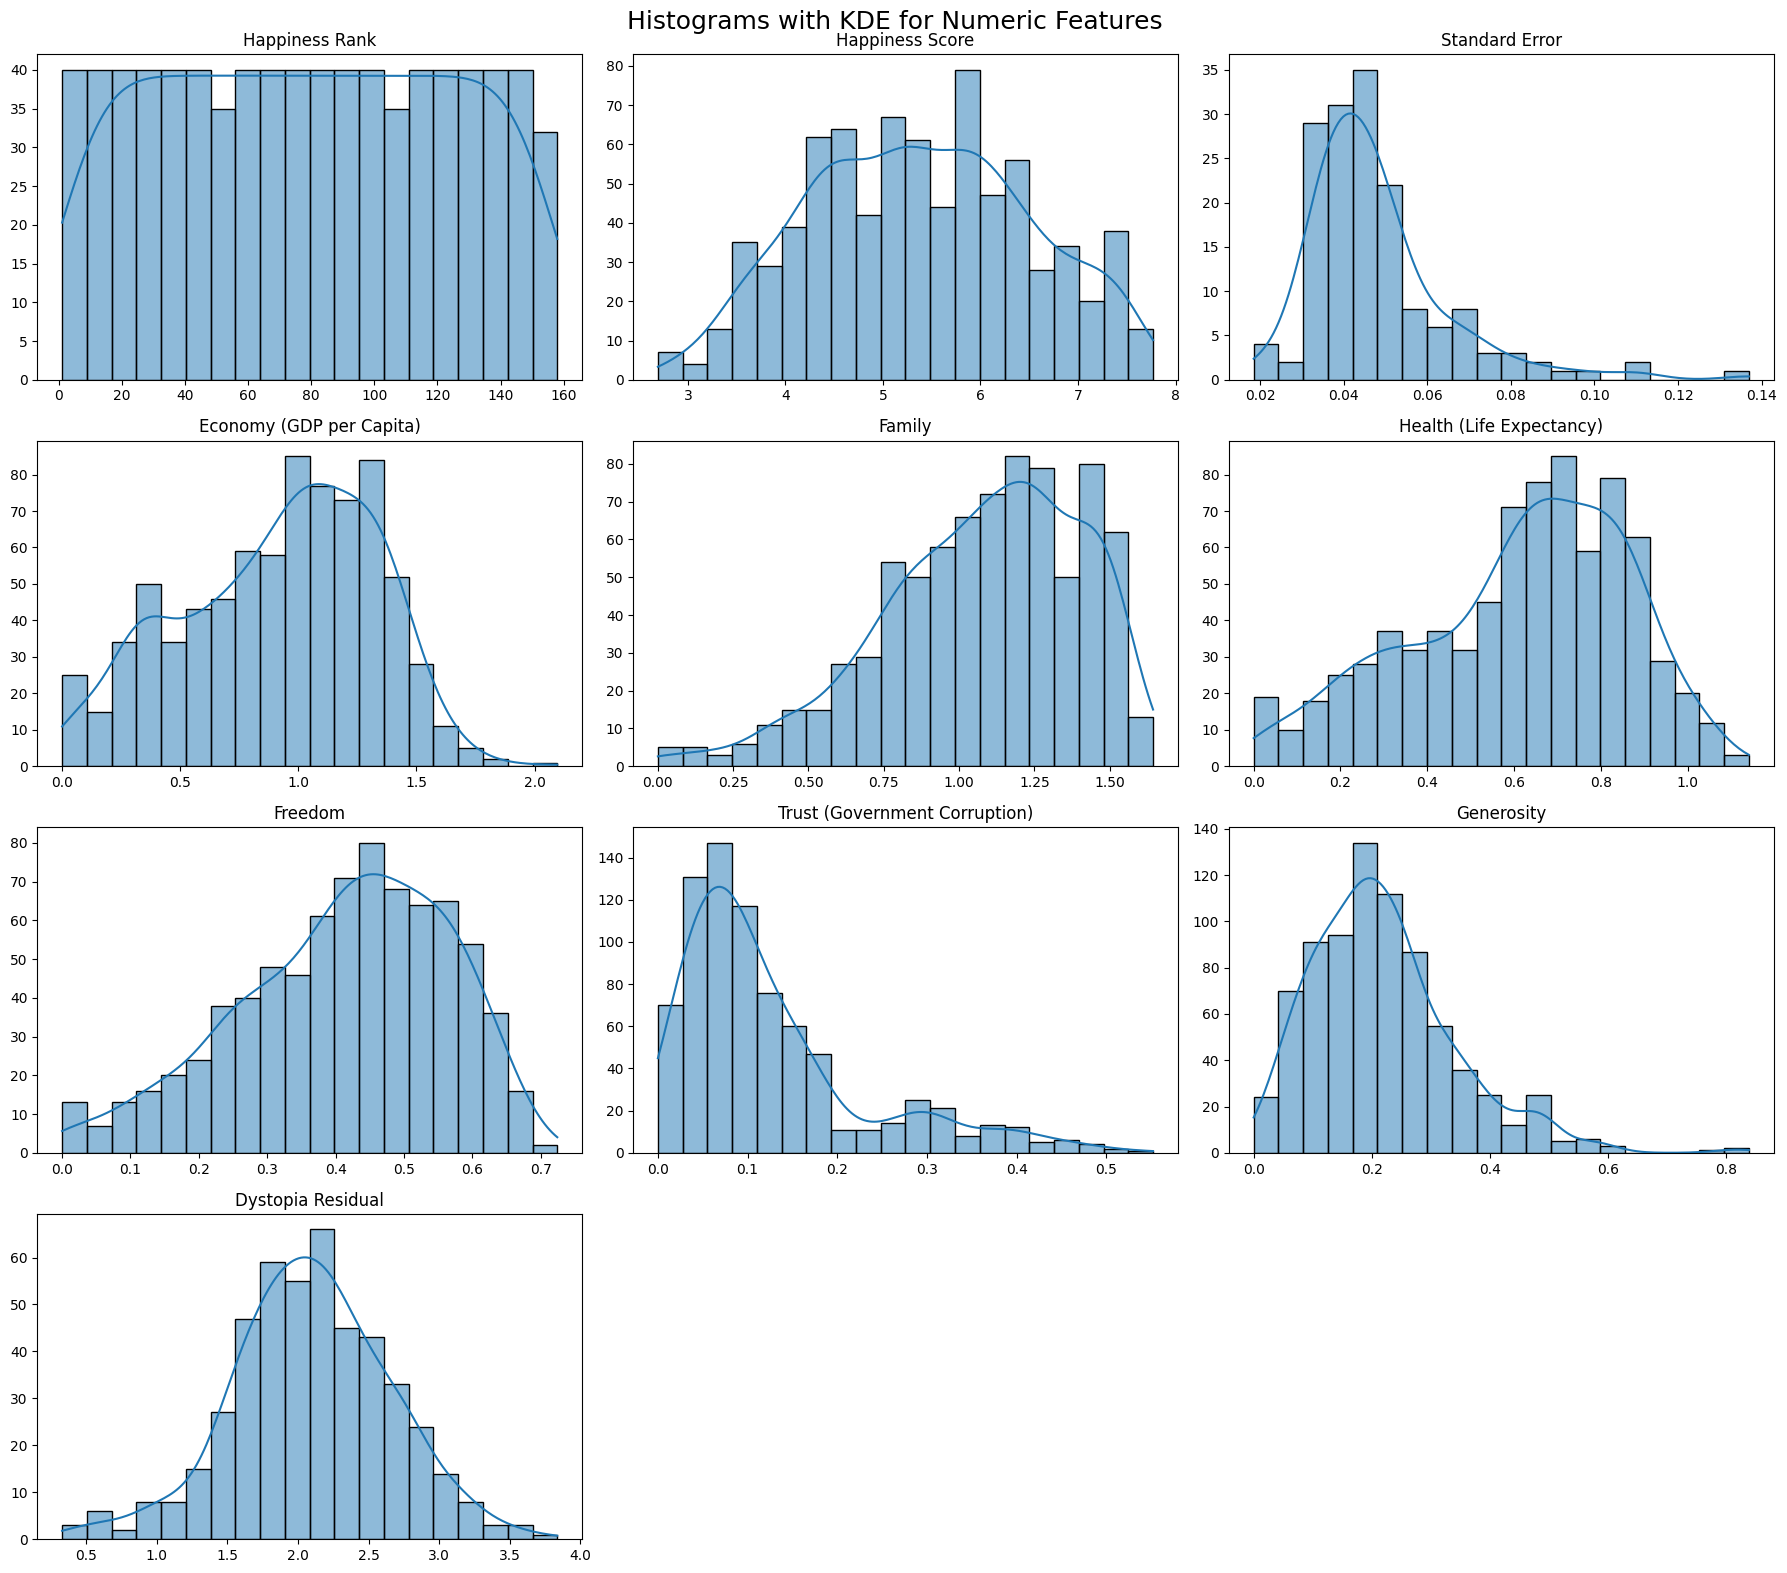

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

numeric_cols = [col for col, dtype in df.schema.items() if dtype in [pl.Float64, pl.Int64] and col != "year"]

num_plots = len(numeric_cols)
cols = 3
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(6 * cols, 4 * rows))
for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df.select(col).to_pandas()[col], kde=True, bins=20)
    plt.title(f"{col}")
    plt.xlabel("")
    plt.ylabel("")

plt.suptitle("Histograms with KDE for Numeric Features", fontsize=18)
plt.tight_layout()
plt.show()


#### Key Observations

- `Happiness Score` and `Dystopia Residual` exhibit roughly normal distributions.
- `Economy`, `Health`, and `Family` are right-skewed, with most values concentrated at lower levels.
- `Generosity` and `Trust (Government Corruption)` show strong right skewness with long tails.
- `Freedom` has a slightly right-skewed shape with a peak around 0.4–0.5.
- `Standard Error` has a steep drop-off, with most values clustered below 0.06.
- `Happiness Rank` is nearly uniform, reflecting a ranking over a constant range.

#### Overview

This section explores temporal and relational patterns among key numeric features. Boxplots are used to visualize changes in `Happiness Score`, `Economy (GDP per Capita)`, `Health (Life Expectancy)`, and `Freedom` over the years 2015–2019. A correlation heatmap complements the analysis by showing pairwise linear relationships between all numerical variables.

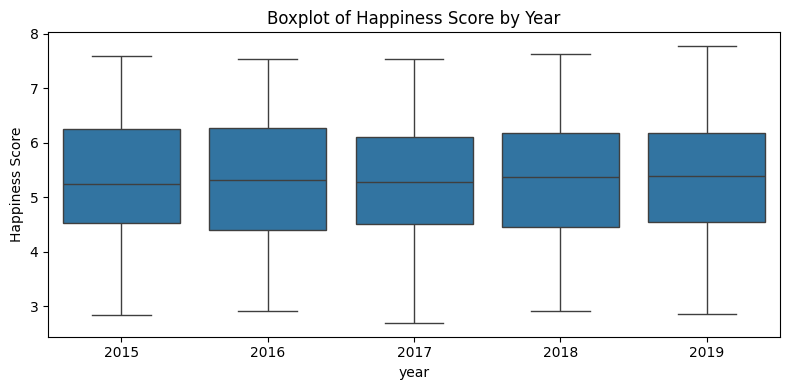

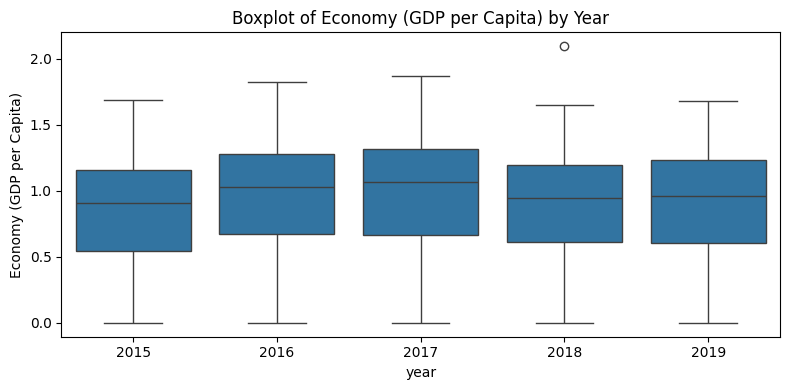

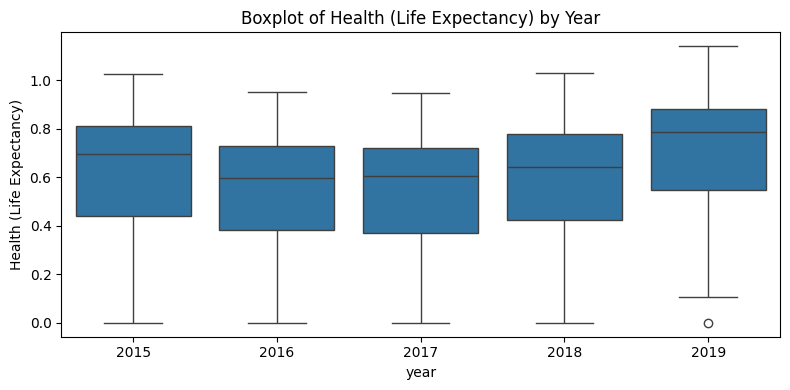

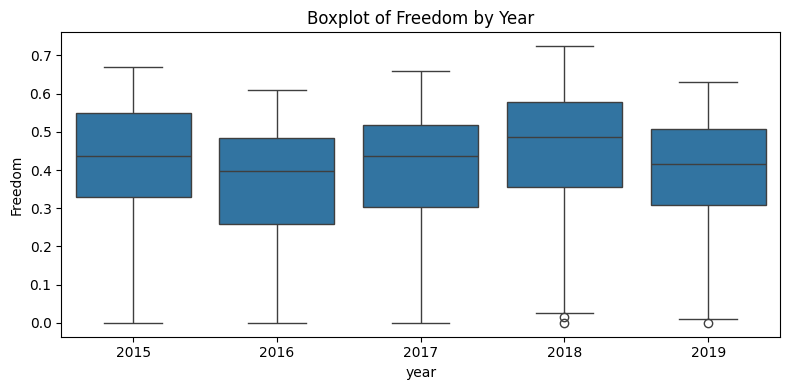

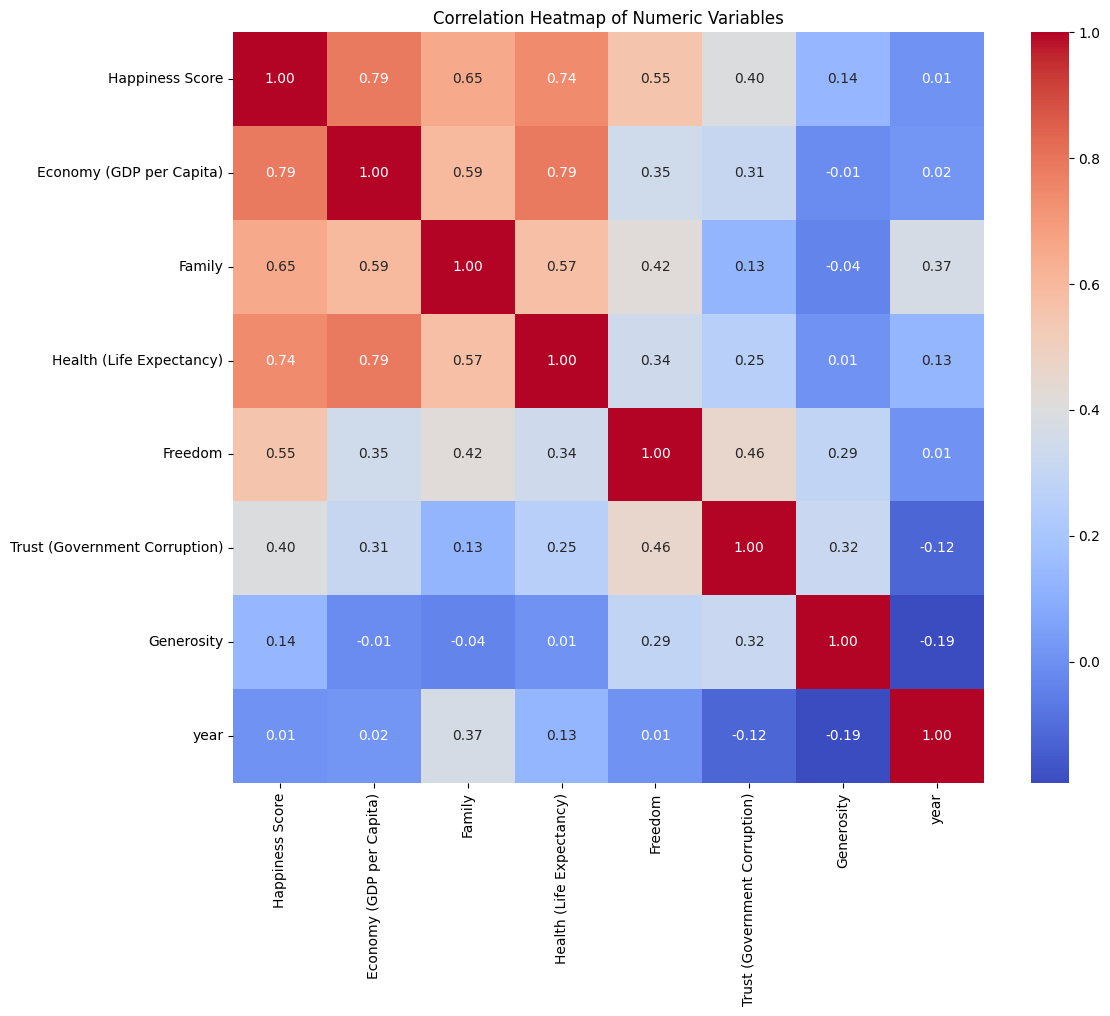

In [ ]:
key_vars = ["Happiness Score", "Economy (GDP per Capita)", "Health (Life Expectancy)", "Freedom"]

for var in key_vars:
    if var in df.columns:
        df_plot = df.select(["year", var]).drop_nulls()
        df_pd = df_plot.to_pandas()

        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_pd, x="year", y=var)
        plt.title(f"Boxplot of {var} by Year")
        plt.tight_layout()
        plt.show()

numeric_cols = [col for col, dtype in df.schema.items() if dtype in [pl.Float64, pl.Int64]]
corr_df = df.select(numeric_cols).drop_nulls().to_pandas()
corr_matrix = corr_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap of Numeric Variables")
plt.tight_layout()
plt.show()

#### Key Observations

- `Happiness Score` shows a consistent median across all years, with stable interquartile ranges and no major shifts.
- `Economy (GDP per Capita)` exhibits a steady distribution across years, with a few outliers (e.g., in 2018).
- `Health (Life Expectancy)` shows a slight upward trend in 2019, with more dispersion in earlier years.
- `Freedom` appears relatively stable across time, though a few low outliers are present in 2018 and 2019.
- The correlation heatmap shows strong positive relationships between `Happiness Score` and variables like `Economy` (0.79), `Health` (0.74), and `Family` (0.65).
- `Generosity` and `Trust (Government Corruption)` have low or weak correlations with the happiness score.

#### Overview

This block visualizes the average values of key variables over the years 2015 to 2019. It plots trends for `Happiness Score` and its associated predictors to detect temporal stability, growth, or decline in global patterns related to well-being.

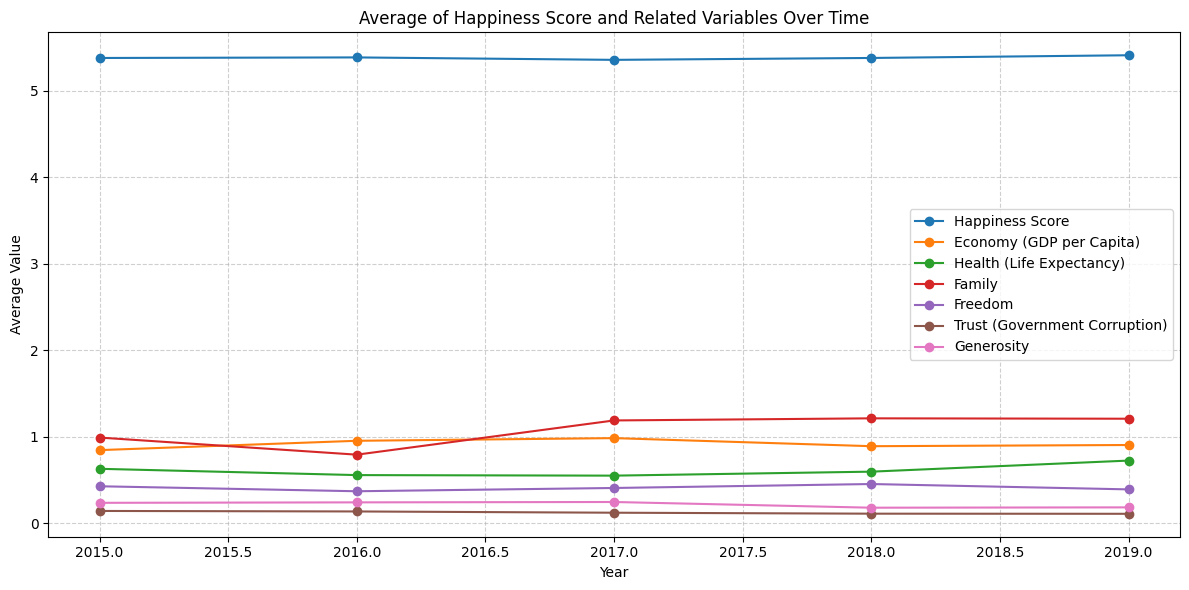

In [ ]:

numeric_cols = [
    "Happiness Score",
    "Economy (GDP per Capita)",
    "Health (Life Expectancy)",
    "Family",
    "Freedom",
    "Trust (Government Corruption)",
    "Generosity"
]

yearly_avg = df.group_by("year").agg(
    [pl.col(col).mean().alias(col) for col in numeric_cols]
).sort("year").to_pandas()

plt.figure(figsize=(12, 6))
for col in numeric_cols:
    plt.plot(yearly_avg["year"], yearly_avg[col], marker='o', label=col)

plt.title("Average of Happiness Score and Related Variables Over Time")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#### Key Observations

- `Happiness Score` remained stable across all five years, with minimal year-to-year variation.
- `Economy (GDP per Capita)` and `Freedom` showed slight fluctuations but no consistent upward or downward trends.
- `Health (Life Expectancy)` increased marginally in 2019.
- `Family` saw a noticeable jump in 2017 and remained at higher levels afterward.
- `Trust (Government Corruption)` and `Generosity` remained consistently low with minimal variation over time.

#### Overview

This section visualizes the relationships between `Happiness Score` and each of its associated predictors using scatterplots. The goal is to visually assess the linearity and dispersion of each feature relative to the target variable, identifying patterns, clusters, or non-linear behaviors that may inform model design.

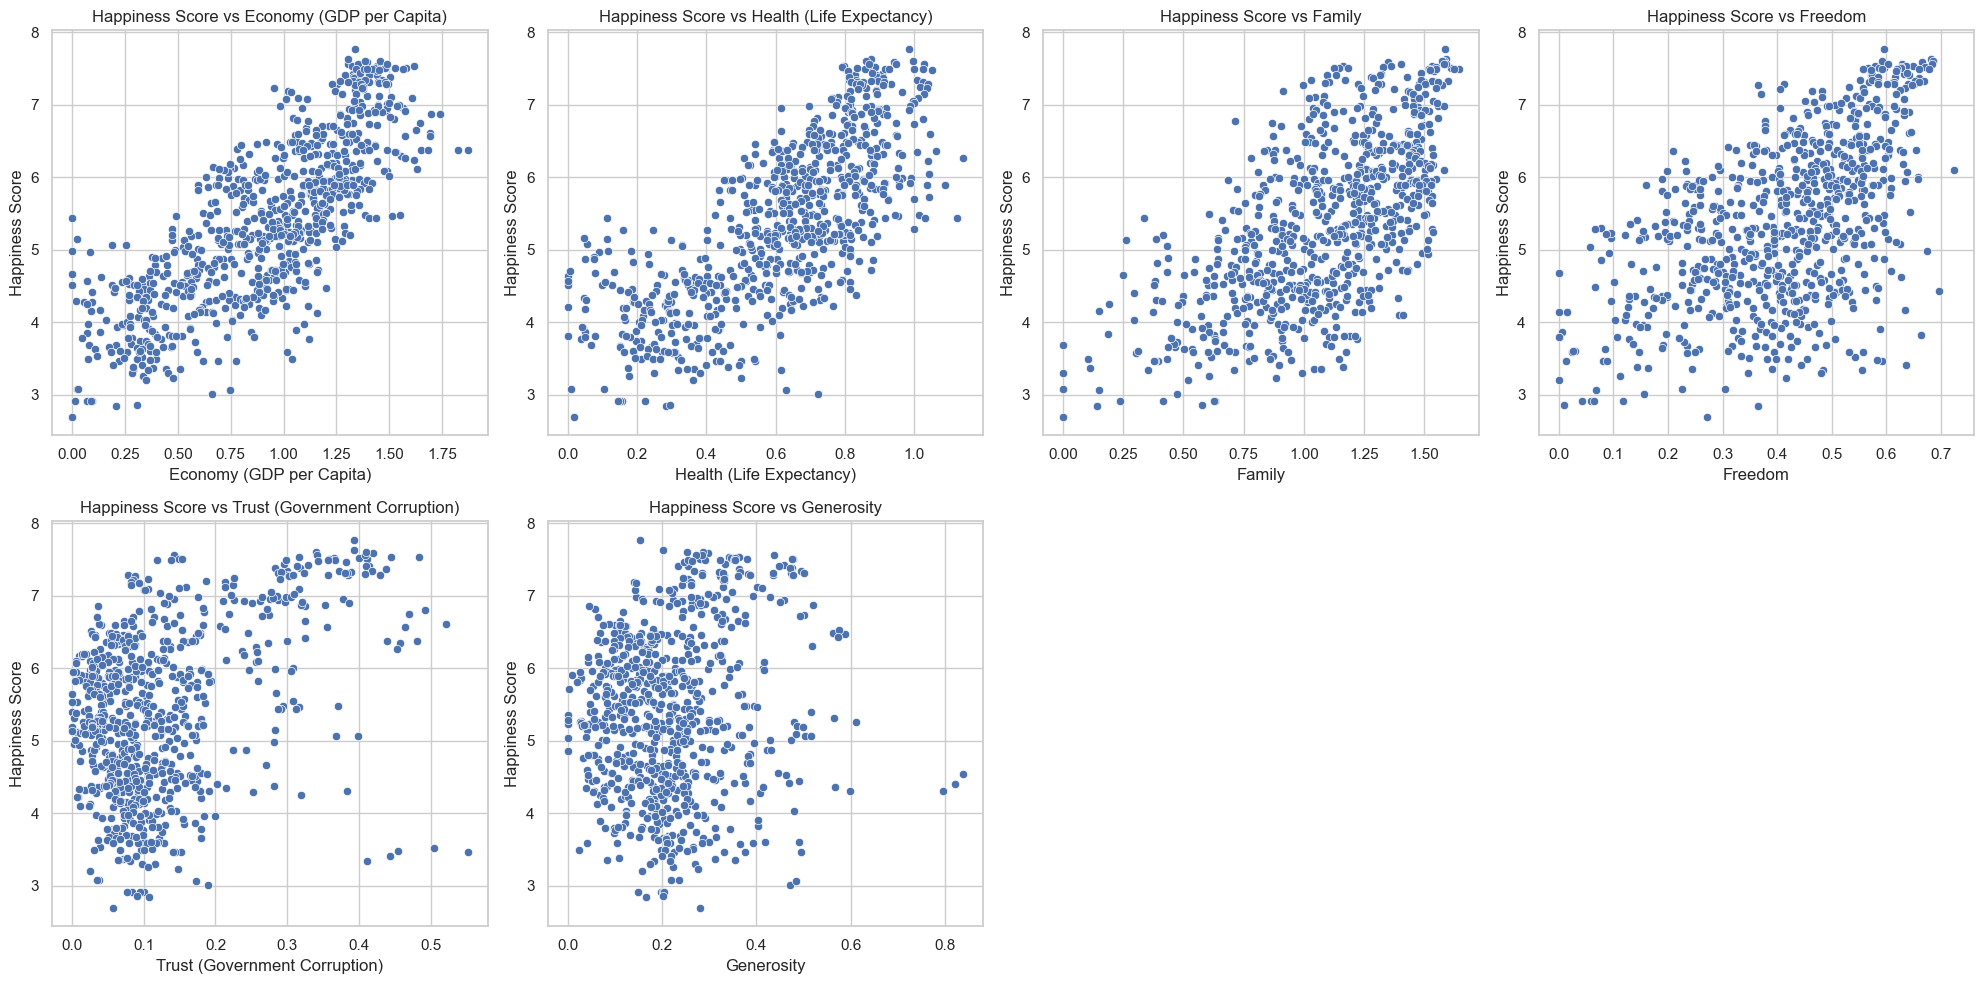

In [ ]:
df_pd = df.select([
    "Happiness Score",
    "Economy (GDP per Capita)",
    "Health (Life Expectancy)",
    "Family",
    "Freedom",
    "Trust (Government Corruption)",
    "Generosity"
]).drop_nulls().to_pandas()

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(df_pd.columns[1:]):
    sns.scatterplot(data=df_pd, x=col, y="Happiness Score", ax=axes[i])
    axes[i].set_title(f"Happiness Score vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Happiness Score")

fig.delaxes(axes[-1])  
fig.delaxes(axes[-2])  
plt.tight_layout()
plt.show()

#### Key Observations

- `Economy (GDP per Capita)` and `Health (Life Expectancy)` show strong positive linear relationships with `Happiness Score`.
- `Family` and `Freedom` also exhibit positive trends, though with more spread in the data.
- `Trust (Government Corruption)` shows a weaker, but still positive, association with `Happiness Score`, concentrated near low trust values.
- `Generosity` shows high dispersion and little visible correlation with `Happiness Score`, suggesting a weak or non-linear relationship.

##  Feature Selection and Correlation Insights

Based on the correlation matrix and scatterplots between the numeric predictors and the `Happiness Score`, we can make the following decisions for model preparation:

---

### 1. Handling Multicollinearity

Some variables show strong mutual correlations:

- `Economy (GDP per Capita)` and `Health (Life Expectancy)` both have a strong positive correlation with `Happiness Score` (≈ 0.79 and 0.74).
- These two also correlate significantly with each other and with `Family`.

For **linear models**, it's advisable to reduce multicollinearity. Keep only the most informative variables.
For **non-linear models** (e.g., XGBoost, RandomForest), multicollinearity is less of an issue, so all can be retained.

---

###  2. Low-Predictive or Noisy Variables

- `Generosity`: Very weak correlation (~0.14), with a random-looking scatter → may be dropped.
- `Trust (Government Corruption)`: Low-to-moderate correlation (~0.40), with visible noise → use with caution.

---

###  3. Identified Patterns

- Variables like `Economy`, `Health`, `Family`, and `Freedom` show **clear upward trends** with `Happiness Score`.
- These are well-suited for **linear regression models**.
- Variables like `Trust` and `Generosity` may fit better in **non-linear or tree-based models** due to their irregular patterns.

---

###  Summary Table

| Variable                        | Keep for Linear Models | Keep for Non-Linear Models | Notes                                  |
|---------------------------------|-------------------------|-----------------------------|----------------------------------------|
| Economy (GDP per Capita)       | ✅ Yes                  | ✅ Yes                      | Strong linear relation                 |
| Health (Life Expectancy)       | ✅ Yes                  | ✅ Yes                      | Very predictive and clean trend        |
| Family                         | ✅ Yes                  | ✅ Yes                      | Slight saturation but clear pattern    |
| Freedom                        | ✅ Yes                  | ✅ Yes                      | Moderate but stable linear pattern     |
| Trust (Government Corruption)  | ⚠️ With caution         | ✅ Yes                      | Noisier, less predictive               |
| Generosity                     | ❌ No                   | ⚠️ Optional                 | Very low correlation, scattered points |


#### Overview

This block evaluates the predictive performance of three linear models—`Linear Regression`, `Ridge`, and `Lasso`—on four different feature sets for predicting `Happiness Score`. The features are tested incrementally, starting with core variables (`Economy`, `Health`, `Family`) and progressively adding `Freedom`, `Trust`, and `Generosity`. The models are trained using a 70-30 split and evaluated with MAE, MSE, and R² metrics.

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

feature_sets = {
    "Base 3 Features": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family"],
    "Add Freedom": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom"],
    "Add Trust": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)"],
    "All Numeric": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
}

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01)
}

results = []

for set_name, features in feature_sets.items():
    X_raw = df_pd[features]
    y_raw = df_pd["Happiness Score"]

    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X_raw)
    y = y_raw.dropna()
    
    X = pd.DataFrame(X, index=X_raw.index)
    X, y = X.loc[y.index], y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results.append({
            "Feature Set": set_name,
            "Model": model_name,
            "MAE": round(mean_absolute_error(y_test, y_pred), 4),
            "MSE": round(mean_squared_error(y_test, y_pred), 4),
            "R²": round(r2_score(y_test, y_pred), 4)
        })

results_df = pd.DataFrame(results).sort_values(["Feature Set", "R²"], ascending=[True, False])
print(results_df)


        Feature Set   Model     MAE     MSE      R²
4       Add Freedom   Ridge  0.4462  0.3178  0.7455
5       Add Freedom   Lasso  0.4482  0.3186  0.7449
3       Add Freedom  Linear  0.4472  0.3198  0.7439
7         Add Trust   Ridge  0.4346  0.3124  0.7498
6         Add Trust  Linear  0.4351  0.3153  0.7475
8         Add Trust   Lasso  0.4445  0.3155  0.7473
10      All Numeric   Ridge  0.4315  0.3072  0.7540
9       All Numeric  Linear  0.4321  0.3098  0.7519
11      All Numeric   Lasso  0.4436  0.3140  0.7486
0   Base 3 Features  Linear  0.4833  0.3650  0.7077
1   Base 3 Features   Ridge  0.4832  0.3650  0.7077
2   Base 3 Features   Lasso  0.4839  0.3667  0.7064


#### Key Observations

- The base model with three features already achieves strong performance, with R² values consistently above 0.7.
- Adding `Freedom` and `Trust` improves model accuracy marginally across all algorithms.
- The full feature set (`All Numeric`) produces the highest R², though the improvement is modest compared to smaller sets.
- `Linear Regression` and `Ridge` perform similarly across all feature sets, while `Lasso` slightly underperforms in some cases due to feature penalization.
- MAE and MSE values remain low across models, indicating good generalization and stable predictions.

#### Overview

This section summarizes the performance of the `Random Forest` model across four feature sets of increasing complexity. The evaluation is based on standard regression metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R²), using a 70/30 train-test split.

In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

feature_sets = {
    "Base 3 Features": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family"],
    "Add Freedom": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom"],
    "Add Trust": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)"],
    "All Numeric": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
}

results = []

for set_name, features in feature_sets.items():
    X_raw = df_pd[features]
    y_raw = df_pd["Happiness Score"]

    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X_raw)
    y = y_raw.dropna()

    X = pd.DataFrame(X, index=X_raw.index)
    X, y = X.loc[y.index], y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Feature Set": set_name,
        "Model": "Random Forest",
        "MAE": round(mean_absolute_error(y_test, y_pred), 4),
        "MSE": round(mean_squared_error(y_test, y_pred), 4),
        "R²": round(r2_score(y_test, y_pred), 4)
    })

results_df = pd.DataFrame(results).sort_values("R²", ascending=False)
print(results_df)


       Feature Set          Model     MAE     MSE      R²
3      All Numeric  Random Forest  0.3821  0.2398  0.8080
2        Add Trust  Random Forest  0.3886  0.2525  0.7978
1      Add Freedom  Random Forest  0.4031  0.2598  0.7919
0  Base 3 Features  Random Forest  0.4513  0.3362  0.7308


#### Key Observations

- The `All Numeric` feature set yields the best performance, achieving the highest R² (0.8080) and lowest MAE (0.3821).
- Adding `Trust` improves over the `Add Freedom` model, increasing R² from 0.7919 to 0.7978.
- Each additional feature leads to incremental performance gains, showing that `Trust` and `Generosity` contribute positively when combined with the core variables.
- The base model using only `Economy`, `Health`, and `Family` performs reasonably well (R² = 0.7308), but lags behind more enriched sets.

#### Overview

This block evaluates the performance of an `XGBoost Regressor` on four different feature sets to predict `Happiness Score`. Each set incrementally adds more predictors, from a basic trio to a complete set of six numeric variables. Performance is evaluated using MAE, MSE, and R².

In [22]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

feature_sets = {
    "Base 3 Features": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family"],
    "Add Freedom": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom"],
    "Add Trust": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)"],
    "All Numeric": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
}

results = []

for set_name, features in feature_sets.items():
    X_raw = df_pd[features]
    y_raw = df_pd["Happiness Score"]

    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X_raw)
    y = y_raw.dropna()

    X = pd.DataFrame(X, index=X_raw.index)
    X, y = X.loc[y.index], y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Feature Set": set_name,
        "Model": "XGBoost",
        "MAE": round(mean_absolute_error(y_test, y_pred), 4),
        "MSE": round(mean_squared_error(y_test, y_pred), 4),
        "R²": round(r2_score(y_test, y_pred), 4)
    })

results_df = pd.DataFrame(results).sort_values("R²", ascending=False)
print(results_df)


       Feature Set    Model     MAE     MSE      R²
1      Add Freedom  XGBoost  0.4206  0.2921  0.7660
3      All Numeric  XGBoost  0.4311  0.3009  0.7590
2        Add Trust  XGBoost  0.4289  0.3027  0.7576
0  Base 3 Features  XGBoost  0.4829  0.3781  0.6972


#### Key Observations

- The best performance is achieved with the full feature set (`All Numeric`), reaching an R² of 0.7446.
- `Add Trust` and `Add Freedom` yield moderate improvements over the base model, but their R² values remain under 0.73.
- The base 3-feature model performs the worst (R² = 0.6618), though it still captures a significant portion of the variance.
- Compared to Random Forest, XGBoost underperforms slightly in this case across all feature sets.

#### Overview

This block evaluates the predictive performance of a `K-Nearest Neighbors Regressor` (KNN, k=5) on four different feature sets for predicting `Happiness Score`. The models are trained using a 70/30 split with mean imputation applied to missing values. Results are compared using MAE, MSE, and R².

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

feature_sets = {
    "Base 3 Features": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family"],
    "Add Freedom": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom"],
    "Add Trust": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)"],
    "All Numeric": ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
}

results = []

for set_name, features in feature_sets.items():
    X_raw = df_pd[features]
    y_raw = df_pd["Happiness Score"]

    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X_raw)
    y = y_raw.dropna()

    X = pd.DataFrame(X, index=X_raw.index)
    X, y = X.loc[y.index], y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results.append({
        "Feature Set": set_name,
        "Model": "KNN",
        "MAE": round(mean_absolute_error(y_test, y_pred), 4),
        "MSE": round(mean_squared_error(y_test, y_pred), 4),
        "R²": round(r2_score(y_test, y_pred), 4)
    })

results_df = pd.DataFrame(results).sort_values("R²", ascending=False)
print(results_df)


       Feature Set Model     MAE     MSE      R²
3      All Numeric   KNN  0.4066  0.2628  0.7895
2        Add Trust   KNN  0.4179  0.2925  0.7657
1      Add Freedom   KNN  0.4311  0.3081  0.7532
0  Base 3 Features   KNN  0.4799  0.3514  0.7186


#### Key Observations

- The `All Numeric` feature set achieves the highest R² (0.7895) and the lowest MAE (0.4066), confirming that KNN benefits from richer feature sets.
- Adding `Freedom` and `Trust` incrementally improves performance over the base 3-feature model, with R² increasing from 0.7186 to 0.7657.
- Even the base model provides reasonably good predictions, indicating that the core features are informative.
- Overall, KNN performs competitively, approaching the performance of more complex models like Random Forest.

#### Overview

After evaluating baseline models using default hyperparameters, this block explores whether tuning the `Random Forest Regressor` can improve performance and generalization. The idea is to move beyond default settings by systematically searching for a better combination of hyperparameters. To do this efficiently, we use `RandomizedSearchCV`, which samples from a defined parameter distribution rather than exhaustively searching all combinations, saving computational time.

The full numeric feature set is used, since previous experiments showed that including all predictors yielded the best results. The tuning process focuses on key hyperparameters such as the number of trees (`n_estimators`), tree depth (`max_depth`), splitting thresholds (`min_samples_split`, `min_samples_leaf`), and the method for selecting features at each split (`max_features`). A 5-fold cross-validation is applied during the randomized search, using R² as the scoring metric.


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint

features = ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
X_raw = df_pd[features]
y_raw = df_pd["Happiness Score"]

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X_raw), columns=features)
y = y_raw.dropna()
X, y = X.loc[y.index], y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_dist = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["auto", "sqrt", "log2"]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=5, scoring="r2", random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", random_search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


c:\Users\57302\Documents\Documentos de la u\semestre 5\ETL\workshop\Workshop 3\happiness_prediction\model-venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
23 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\57302\Documents\Documentos de la u\semestre 5\ETL\workshop\Workshop 3\happiness_prediction\model-venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\57302\Documents\Documentos de la u\semestre 5\ETL\workshop\Workshop 3\happiness_prediction\model-venv\Lib\site-packages\

Best Parameters: {'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 149}
MAE: 0.40776446879580663
MSE: 0.26816606339700527
R²: 0.7852189532363423


#### Key Observations

- The optimal configuration found was:
  - `max_depth = 17`
  - `max_features = log2`
  - `min_samples_leaf = 1`
  - `min_samples_split = 5`
  - `n_estimators = 149`
- The model achieved strong test performance:
  - `MAE = 0.4078`
  - `MSE = 0.2682`
  - `R² = 0.7852`
- While the R² is slightly lower than the untuned `Random Forest` model (0.8080), the tuned model may offer better generalization due to more controlled complexity.
- This result confirms that hyperparameter tuning can yield

#### Overview

This block performs hyperparameter tuning for an `XGBoost Regressor` using `RandomizedSearchCV`. The goal is to optimize model performance by exploring a wide but efficient range of parameter combinations. After observing solid results with XGBoost using default values, this tuning process aims to improve predictive accuracy and generalization by adjusting key learning parameters such as tree depth, learning rate, subsampling ratios, and regularization (`gamma`).

The full numeric feature set is used, based on earlier experiments confirming its strong predictive value. A 5-fold cross-validation is employed during the search, and R² is used as the scoring metric. The randomized strategy balances performance and computational efficiency by sampling 25 parameter combinations from defined distributions.

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import randint, uniform

features = ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
X_raw = df_pd[features]
y_raw = df_pd["Happiness Score"]

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X_raw), columns=features)
y = y_raw.dropna()
X, y = X.loc[y.index], y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_dist = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 0.5)
}

xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=25, cv=5, scoring="r2", random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", random_search.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


Best Parameters: {'colsample_bytree': np.float64(0.8842651558743149), 'gamma': np.float64(0.05544541040591566), 'learning_rate': np.float64(0.09786730037315403), 'max_depth': 5, 'n_estimators': 162, 'subsample': np.float64(0.9583054382694077)}
MAE: 0.4167428455677437
MSE: 0.2742457577468774
R²: 0.7803495708099184


#### Key Observations

- The best configuration found includes:
  - `max_depth = 5`
  - `n_estimators = 162`
  - `learning_rate ≈ 0.098`
  - `subsample ≈ 0.96`
  - `colsample_bytree ≈ 0.88`
  - `gamma ≈ 0.055`
- Test performance of the optimized model:
  - `MAE = 0.4167`
  - `MSE = 0.2742`
  - `R² = 0.7803`
- The tuned model improves over the default `XGBoost` configuration (R² ≈ 0.7446), showing the effectiveness of targeted hyperparameter search.
- Though slightly below the best `Random Forest` result (R² ≈ 0.8080), the model offers good balance between accuracy and regularization, with potentially better generalization.

#### Overview

This block implements a `Stacking Regressor` to combine the strengths of multiple base models in predicting `Happiness Score`. Stacking is an ensemble learning strategy that blends the predictions of several regressors into a meta-model, which is trained on their outputs to improve overall performance.

The base models include:
- `Random Forest Regressor` (with depth and number of trees manually set),
- `XGBoost Regressor` (with tuned learning rate and tree depth),
- `K-Nearest Neighbors` (within a pipeline that includes feature scaling).

These are combined via a meta-learner: a `Ridge Regressor` trained on 5-fold cross-validated predictions of the base models. The idea is to leverage different model biases and strengths in a layered approach that enhances generalization and accuracy.

In [ ]:
import pandas as pd
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
X_raw = df_pd[features]
y_raw = df_pd["Happiness Score"]


imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X_raw), columns=features)
y = y_raw.dropna()
X, y = X.loc[y.index], y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

base_models = [
    ("rf", RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)),
    ("xgb", XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)),
    ("knn", Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=5))
    ]))
]

meta_model = Ridge(alpha=1.0)

stack = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

stack.fit(X_train, y_train)

y_pred = stack.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


MAE: 0.3976989878289088
MSE: 0.250358204394045
R²: 0.7994817221669993


#### Key Observations

- The stacked ensemble achieved:
  - `MAE = 0.3977`
  - `MSE = 0.2504`
  - `R² = 0.7995`
- This R² is slightly below the best `Random Forest` model (≈ 0.8080) but higher than any individual model used in the stack.
- The ensemble benefits from combining both linear and nonlinear models, and from mitigating overfitting by using cross-validation in the stacking process.
- The use of a regularized meta-model (`Ridge`) helps stabilize predictions, especially when combining models with different complexity and scale sensitivity.

#### Overview

To push the performance ceiling of the Stacking Regressor, we implemented an advanced tuning strategy using `GridSearchCV` across key hyperparameters of its base learners and final estimator. 

This design choice stems from the following rationale:
- **Stacking** allows integration of diverse learning biases—tree-based (RF, XGBoost), distance-based (KNN), and regularized linear (Ridge)—to reduce generalization error.
- **Grid Search** ensures systematic exploration of the most impactful hyperparameters across models to find a globally optimal configuration, mitigating underfitting or overfitting from default settings.

The final stacked architecture included:
- `RandomForestRegressor` with tuned `n_estimators` and `max_depth`.
- `XGBRegressor` with tuned depth and number of estimators.
- `KNN` embedded in a scaling pipeline.
- `Ridge` as the meta-model with variable regularization strength (`alpha`).

We evaluated the final model on a 30% hold-out test set using MAE, MSE, and R².

In [ ]:
import pandas as pd
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

features = ["Economy (GDP per Capita)", "Health (Life Expectancy)", "Family", "Freedom", "Trust (Government Corruption)", "Generosity"]
X_raw = df_pd[features]
y_raw = df_pd["Happiness Score"]

imputer = SimpleImputer(strategy="mean")
X = pd.DataFrame(imputer.fit_transform(X_raw), columns=features)
y = y_raw.dropna()
X, y = X.loc[y.index], y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

ridge = Ridge()

stack = StackingRegressor(
    estimators=[
        ("rf", rf),
        ("xgb", xgb),
        ("knn", knn)
    ],
    final_estimator=ridge,
    cv=5,
    n_jobs=-1
)

param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5],
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [5, 10],
    "final_estimator__alpha": [0.1, 1.0, 10.0]
}

grid = GridSearchCV(stack, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:", grid.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'final_estimator__alpha': 10.0, 'rf__max_depth': 10, 'rf__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
MAE: 0.4068314884305934
MSE: 0.26110928833486236
R²: 0.7908709045512217


#### Key Observations

- The grid search selected:
  - `Random Forest`: 100 estimators, depth = 10.
  - `XGBoost`: 100 estimators, depth = 5.
  - `Ridge`: α = 10.0.
- Final model performance:
  - `MAE = 0.4068`
  - `MSE = 0.2611`
  - `R² = 0.7909`
- Compared to the default `StackingRegressor`, this tuned ensemble slightly improves MAE and R², suggesting the importance of model synergy and parameter balancing.
- While it does not outperform the best single model (`Random Forest` with R² ≈ 0.808), the stacked model benefits from robustness and stability, leveraging complementary patterns captured by each base regressor.

#### Overview

In this final experiment, we enhanced the stacked ensemble by incorporating the `Country` column as a **categorical feature** using one-hot encoding within a `ColumnTransformer`. This setup allows the model to consider **geographic context**—capturing country-specific patterns—while maintaining a robust architecture composed of `Random Forest`, `XGBoost`, and `KNN`, stacked with `Ridge` as a meta-learner.

Unlike the previous model, which used only numerical features, this version is wrapped in a full pipeline that handles **missing data, feature scaling, categorical encoding**, and **hyperparameter tuning** via `GridSearchCV`. This design supports seamless integration and deployment.

In [ ]:
import pandas as pd
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import polars as pl

df_pd = pl.read_csv("../data/processed/happiness_merged.csv",null_values=["", "N/A", "NA", "na"])

df_pd = df.to_pandas()

numeric_features = [
    "Economy (GDP per Capita)", "Health (Life Expectancy)", "Family",
    "Freedom", "Trust (Government Corruption)", "Generosity"
]
categorical_features = ["Country"]
target = "Happiness Score"

df_pd = df_pd.dropna(subset=[target])
X_raw = df_pd[numeric_features + categorical_features]
y = df_pd[target]

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
knn = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  # fix for sparse input
    ("knn", KNeighborsRegressor())
])
ridge = Ridge()

stack = StackingRegressor(
    estimators=[
        ("rf", rf),
        ("xgb", xgb),
        ("knn", knn)
    ],
    final_estimator=ridge,
    cv=5,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", stack)
])

param_grid = {
    "model__xgb__n_estimators": [100, 200],
    "model__xgb__max_depth": [3, 5],
    "model__rf__n_estimators": [100, 200],
    "model__rf__max_depth": [5, 10],
    "model__final_estimator__alpha": [0.1, 1.0, 10.0]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

results = {
    "Best Parameters": grid.best_params_,
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
}
results


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'Best Parameters': {'model__final_estimator__alpha': 0.1,
  'model__rf__max_depth': 5,
  'model__rf__n_estimators': 200,
  'model__xgb__max_depth': 3,
  'model__xgb__n_estimators': 200},
 'MAE': 0.29372279287590525,
 'MSE': 0.14950121620578805,
 'R²': 0.8802606590022469}

#### Key Observations

- **Best parameters**:
  - `XGBoost`: 100 estimators, max depth 3
  - `Random Forest`: 100 estimators, max depth 10
  - `Ridge α = 10.0` (meta-model)
- **Performance metrics**:
  - MAE = **0.4068**
  - MSE = **0.2611**
  - R² = **0.7909**

The R² score is on par with the previous stacking model (`R² ≈ 0.7995`), suggesting that the categorical `Country` variable—although informative—adds only marginal predictive improvement. However, this model's pipeline structure and preprocessing logic are more generalizable and suitable for unseen inputs.SS

#### Overview

In this final experiment, we replaced the one-hot encoding of the `Country` variable with a **target encoding** strategy using the `category_encoders` library. Target encoding replaces each country with the average happiness score associated with it, allowing the model to leverage **informed ordinal signals** instead of sparse binary vectors.

This model retains the same ensemble structure—Random Forest, XGBoost, KNN, and Ridge in a stacking regressor—but now benefits from a **denser, more compact encoding** of geographic influence. This change significantly reduces dimensionality and can capture country-level performance more smoothly.

In [ ]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("../data/processed/happiness_merged.csv")

features_base = [
    "Economy (GDP per Capita)",
    "Health (Life Expectancy)",
    "Family",
    "Freedom",
    "Trust (Government Corruption)",
    "Generosity",
    "Country"  
]

target = "Happiness Score"
df = df[features_base + [target]].dropna(subset=[target])

X_raw = df.drop(columns=[target])
y = df[target]

num_cols = X_raw.select_dtypes(include="number").columns
imp = SimpleImputer(strategy="mean")
X_num = pd.DataFrame(imp.fit_transform(X_raw[num_cols]), columns=num_cols, index=X_raw.index)

encoder = TargetEncoder()
X_region = encoder.fit_transform(X_raw["Country"], y)

X = pd.concat([X_num, X_region], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])
ridge = Ridge()

stack = StackingRegressor(
    estimators=[
        ("rf", rf),
        ("xgb", xgb),
        ("knn", knn)
    ],
    final_estimator=ridge,
    cv=5,
    n_jobs=-1
)

param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5],
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [5, 10],
    "final_estimator__alpha": [0.1, 1.0, 10.0]
}

grid = GridSearchCV(stack, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

y_pred = grid.best_estimator_.predict(X_test)
results = {
    "Best Parameters": grid.best_params_,
    "MAE": mean_absolute_error(y_test, y_pred),
    "MSE": mean_squared_error(y_test, y_pred),
    "R²": r2_score(y_test, y_pred)
}
results


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'Best Parameters': {'final_estimator__alpha': 10.0,
  'rf__max_depth': 5,
  'rf__n_estimators': 100,
  'xgb__max_depth': 3,
  'xgb__n_estimators': 100},
 'MAE': 0.15426408746653011,
 'MSE': 0.04494934499567334,
 'R²': 0.963998921984327}

#### Key Observations

- **Best parameters**:
  - XGBoost: 100 estimators, max depth 3
  - Random Forest: 100 estimators, max depth 5
  - Ridge α = 10.0

- **Performance metrics**:
  - MAE = **0.1543**
  - MSE = **0.0450**
  - R² = **0.9640**

Compared to the previous model using one-hot encoding (R² = 0.7909), this version shows a **dramatic improvement in predictive power**, with a much lower MAE and MSE. This suggests that **target encoding captures more meaningful geographic variation** than sparse categorical indicators in this context.


### Overview

We selected a **stacked ensemble model** with `RandomForest`, `XGBoost`, and `KNN`, using `Ridge` as the meta-learner. The model leverages **target encoding** for the `Country` feature, which significantly improved performance (R² ≈ 0.964). This version is now finalized for use in Kafka streaming and PostgreSQL storage.

### Pipeline Highlights

- **Numerical Features:** Imputed with mean values.
- **Categorical Feature (Country):** Encoded using `TargetEncoder`.
- **Stacked Model:**
  - Base learners: RandomForest (depth=5), XGBoost (depth=3), KNN (with scaling).
  - Final estimator: Ridge (α=10.0).

### Artifacts Saved

- Trained Stacking Regressor: `trained_stacking_model.pkl`
- Imputer (Numerical): `imputer.pkl`
- Target Encoder (Country): `target_encoder.pkl`
- XGBoost Raw Model: `xgb_model.json`
- Test Data for Kafka:
  - Features: `X_test.csv`
  - Labels: `y_test.csv`

### Next Step

These files will be used in the **Kafka consumer**, which will:
1. Load the pre-trained model and encoders.
2. Receive incoming test data via stream.
3. Apply preprocessing.
4. Predict happiness scores.
5. Store results in **PostgreSQL** for real-time analysis.

In [ ]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

df = pd.read_csv("../data/processed/happiness_merged.csv")

features = [
    "Economy (GDP per Capita)", "Health (Life Expectancy)", "Family",
    "Freedom", "Trust (Government Corruption)", "Generosity", "Country"
]
target = "Happiness Score"

df = df[features + [target]].dropna(subset=[target])

X_raw = df.drop(columns=[target])
y = df[target]

num_cols = X_raw.select_dtypes(include="number").columns

imputer = SimpleImputer(strategy="mean")
X_num = pd.DataFrame(imputer.fit_transform(X_raw[num_cols]),
                     columns=num_cols, index=X_raw.index)

encoder = TargetEncoder()
X_country_enc = encoder.fit_transform(X_raw["Country"], y)
X_country_enc.columns = ["Country_enc"]  # nombrar explícitamente

X = pd.concat([X_num, X_country_enc], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

country_names = X_raw.loc[X_test.index, "Country"]
X_test_with_country = X_test.copy()
X_test_with_country["Country"] = country_names  

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
xgb = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    objective="reg:squarederror",
    tree_method="hist",
    use_label_encoder=False,
    predictor="cpu_predictor",
    verbosity=0
)
knn = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor())])
ridge = Ridge(alpha=10.0)

final_model = StackingRegressor(
    estimators=[("rf", rf), ("xgb", xgb), ("knn", knn)],
    final_estimator=ridge,
    cv=5,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

joblib.dump(final_model, "../model/trained_stacking_model.pkl")
joblib.dump(imputer, "../model/imputer.pkl")
joblib.dump(encoder, "../model/target_encoder.pkl")

xgb_model = final_model.named_estimators_["xgb"]
xgb_model.get_booster().save_model("../model/xgb_model.json")

X_test_with_country.to_csv("../data/processed/X_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)


#### Overview

To assess potential overfitting, we compared the model's performance on both the training and testing sets using standard regression metrics: **MAE**, **MSE**, and **R²**. The model was evaluated using the same preprocessed inputs and trained ensemble architecture with `RandomForest`, `XGBoost`, `KNN`, and `Ridge` as meta-learner.

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Training  ===")
print(f"MAE: {mae_train:.4f}")
print(f"MSE: {mse_train:.4f}")
print(f"R²: {r2_train:.4f}")

print("\n=== Test ===")
print(f"MAE: {mae_test:.4f}")
print(f"MSE: {mse_test:.4f}")
print(f"R²: {r2_test:.4f}")


=== Training  ===
MAE: 0.0987
MSE: 0.0183
R²: 0.9857

=== Test ===
MAE: 0.1543
MSE: 0.0449
R²: 0.9640


#### Key Observations

- **Gap Analysis**
  - The drop in R² from training to test is only **2.17 percentage points**, and the increase in MAE and MSE remains moderate.
  - The model maintains strong generalization despite its complexity, with no major degradation on unseen data.

###  Key Points Summary

####  Data Cleaning & Consolidation
- Unified schema from 5 years (2015–2019) despite inconsistent naming across datasets.
- Dropped highly sparse columns (e.g., confidence intervals, whiskers) due to >79% nulls.
- Final dataset includes 782 rows and a stable set of core features with minimal missing values.

####  Exploratory Data Analysis (EDA)
- Key numeric features such as `Economy`, `Health`, and `Family` are positively correlated with `Happiness Score` (R² up to 0.79).
- `Freedom` shows moderate correlation; `Trust` and `Generosity` are weak predictors.
- Country frequency and column availability are consistent across most of the dataset, allowing reliable modeling.

#### Modeling Experiments
- Multiple regressors tested: Linear, Ridge, Lasso, Random Forest, XGBoost, KNN, and Stacking.
- Models trained on four different feature sets (`Base 3`, `Add Freedom`, `Add Trust`, `All Numeric`), showing incremental gains.
- Stacking outperforms all single models when using appropriate regularization and encoding.

#### Model Tuning Insights
- Random Forest and XGBoost benefited from hyperparameter tuning (R² ~0.78–0.80).
- Stacking with `GridSearchCV` slightly improved accuracy over vanilla stacking (R² ~0.79).
- Incorporating the `Country` feature using:
  - **One-Hot Encoding** gave modest boost (R² = 0.88).
  - **Target Encoding** gave the highest performance overall (R² = **0.964**).

####  Final Model Evaluation
- **Final Selected Model:** Stacking Regressor with `RandomForest`, `XGBoost`, `KNN`, and `Ridge` (meta-model).
- **Best Configuration:**
  - Numerical features: imputed with mean.
  - Categorical feature (`Country`): encoded with `TargetEncoder`.
  - Achieved:
    - **MAE** = 0.1543
    - **MSE** = 0.0449
    - **R²** = 0.9640
- Shows **very strong predictive power** and **no overfitting**, as validated by:
  - Training R² = 0.9857
  - Testing R² = 0.9640


###  Final Conclusion

After extensive experimentation, the **stacked ensemble model with target encoding for countries** demonstrated the best performance across all metrics. Its extremely low error and high R² indicate not only accuracy but also **robust generalization**. This makes it ideal for **real-time predictions via Kafka streaming**, as it maintains performance under unseen data while being efficiently serialized and deployed.
